Kaggle API Connection

In [43]:
!pip install --upgrade --quiet kaggle
!pip install kagglehub

from google.colab import files
import os
import json

# Create Kaggle directory
!mkdir -p ~/.kaggle

# Create kaggle.json template
token = {
    "username": "pythonsolutions116",
    "key": "8670d331d263f5a47f888a1d3d9a88f9"
}

# Save the token file
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(token, f)

# Set appropriate permissions
!chmod 600 /root/.kaggle/kaggle.json

# Now download the dataset
import kagglehub

def download_hanacaraka_dataset():
    try:
        path = kagglehub.dataset_download("vzrenggamani/hanacaraka")
        print("Dataset successfully downloaded to:", path)
        return path
    except Exception as e:
        print(f"Error downloading dataset: {str(e)}")
        print("\nPlease ensure you have:")
        print("1. Replaced 'YOUR_KAGGLE_USERNAME' with your actual Kaggle username")
        print("2. Replaced 'YOUR_KAGGLE_API_KEY' with your actual Kaggle API key")
        print("3. Your Kaggle account has accepted the dataset's terms of use")
        return None

# Download the dataset
dataset_path = download_hanacaraka_dataset()

Dataset successfully downloaded to: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35


In [74]:
# Install required libraries (if not already installed)
!pip install kagglehub
!pip install torch torchvision

import os
import kagglehub
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Dataset Class with Invalid File Handling

In [75]:
class HanacarakaDataset:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.data = self._load_data()
        self.perform_eda()

    def _load_data(self):
        print("Loading dataset...")
        images, labels = [], []
        for path in self.dataset_path.rglob('*.*'):  # Match all file extensions
            try:
                # Verify file is an image
                with Image.open(path) as img:
                    img.verify()
                images.append(str(path))
                labels.append(path.parent.name)
            except (UnidentifiedImageError, OSError):
                print(f"Skipping invalid file: {path}")
        print(f"Loaded {len(images)} valid images across {len(set(labels))} classes.")
        return pd.DataFrame({'filename': images, 'label': labels})

    def perform_eda(self):
        print("\nPerforming EDA...")
        # Plot class distribution
        plt.figure(figsize=(15, 6))
        sns.countplot(data=self.data, x='label')
        plt.title('Distribution of Hanacaraka Characters')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Display image samples
        print("\nDisplaying sample images...")
        unique_labels = sorted(self.data['label'].unique())
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        axes = axes.ravel()

        for idx, label in enumerate(unique_labels[:20]):  # Display first 20 classes
            sample = self.data[self.data['label'] == label]['filename'].iloc[0]
            img = Image.open(sample)
            axes[idx].imshow(img)
            axes[idx].set_title(label)
            axes[idx].axis('off')
        plt.tight_layout()
        plt.show()

Dataset Preparation

Loading dataset...
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/README.md
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/LICENSE.md
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/ja/4694023059412567494_base64_34.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/ha/4694803355817399930_base64_5.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/nya/4695963539838682931_base64_38.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/la/4695952290615665559_base64_27.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/ga/4696394596413810473_base64_43.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/dha/4696038101413220221_base64_32.png
Skipping 

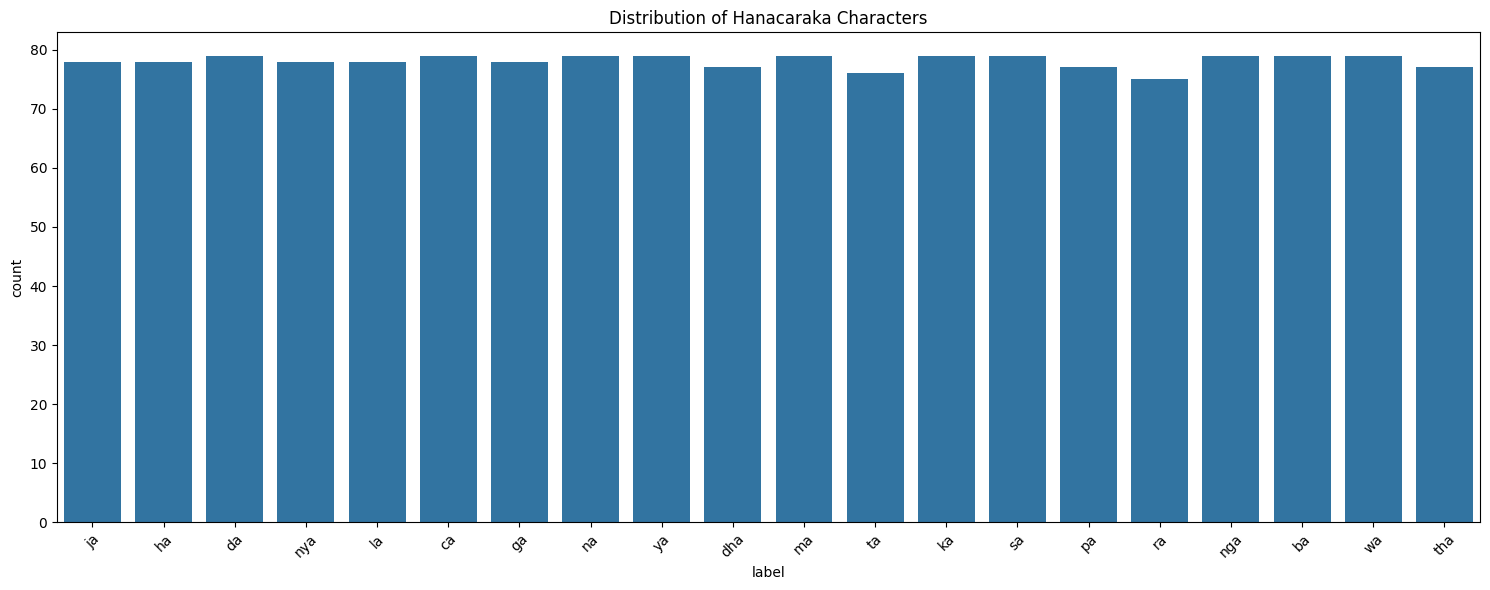


Displaying sample images...


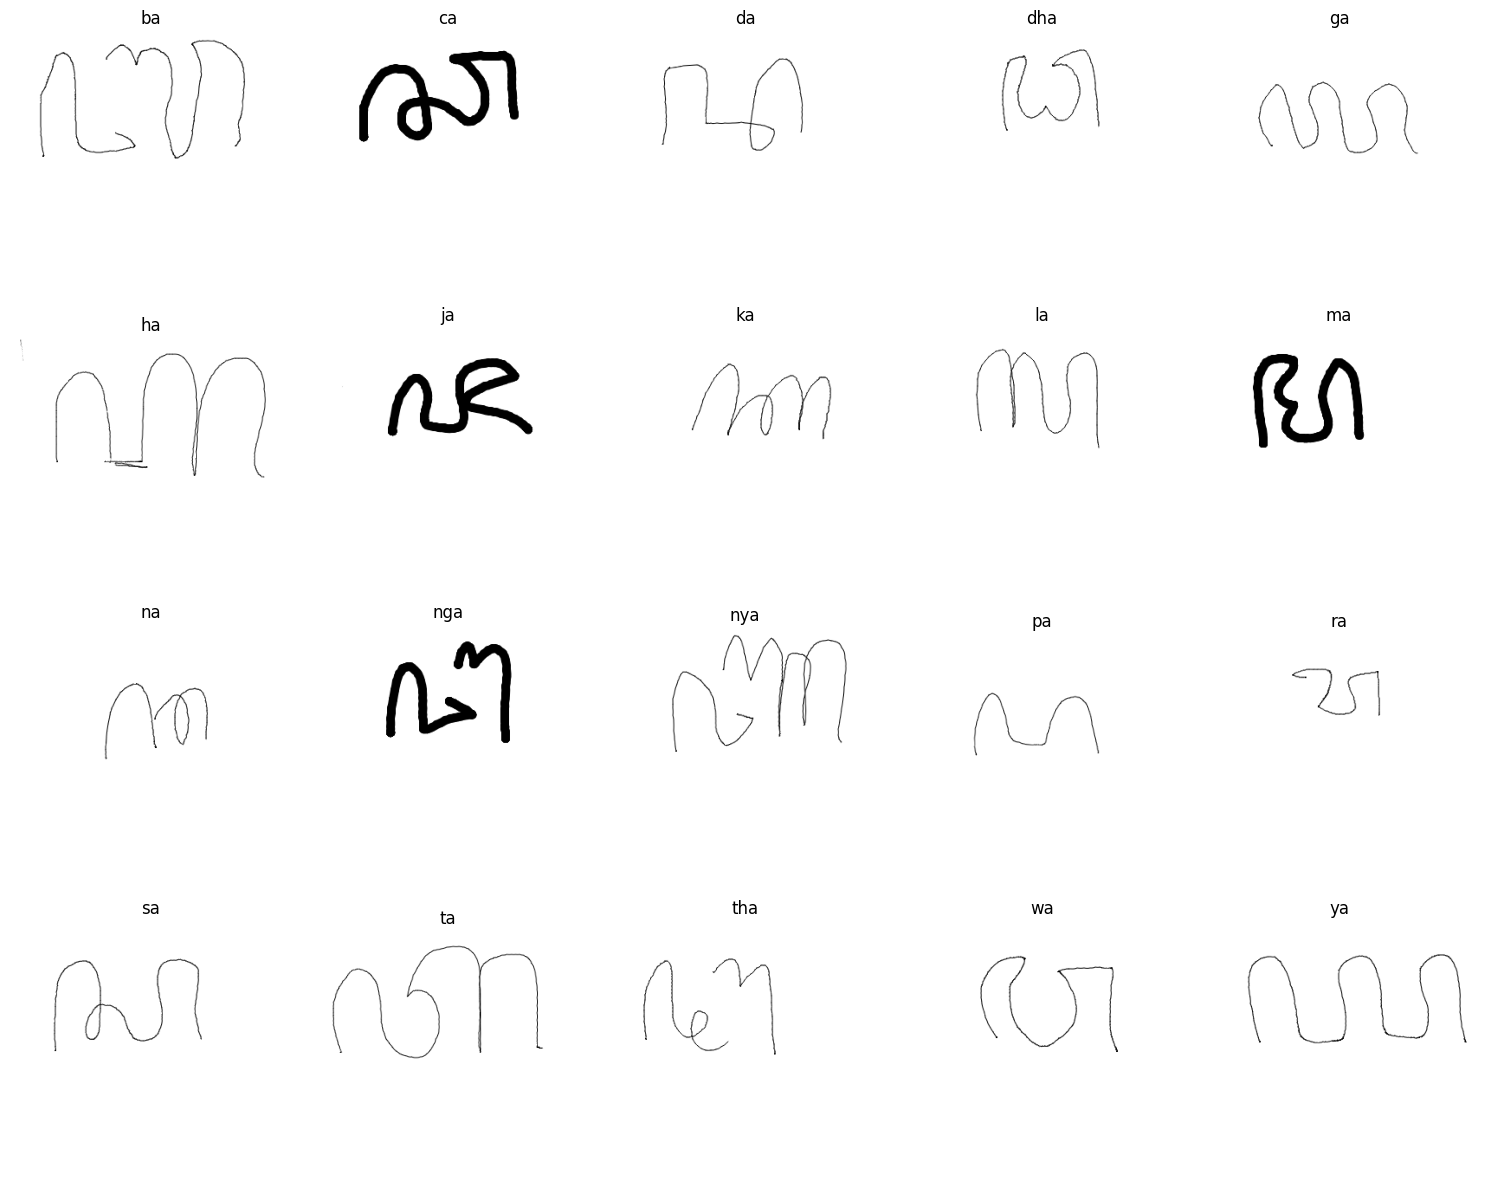

In [76]:
# Load dataset and perform EDA
dataset_path = kagglehub.dataset_download("vzrenggamani/hanacaraka")
dataset = HanacarakaDataset(dataset_path)

# Encode labels and split data
label_encoder = {label: idx for idx, label in enumerate(dataset.data['label'].unique())}
labels = [label_encoder[label] for label in dataset.data['label']]

train_files, val_files, train_labels, val_labels = train_test_split(
    dataset.data['filename'], labels, test_size=0.2, random_state=42
)

DataLoader and ImageDataset

In [77]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.files[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image: {self.files[idx]}, skipping...")
            return None

train_dataset = ImageDataset(train_files.values, train_labels)
val_dataset = ImageDataset(val_files.values, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

Training samples: 1249
Validation samples: 313


CNN Model

CNN Architecture

In [89]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

Data Augmentation

In [90]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_files.values, train_labels, transform=transform_train)
val_dataset = ImageDataset(val_files.values, val_labels, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Hyperparameters

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder)
enhanced_cnn_model = EnhancedCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(enhanced_cnn_model.parameters(), lr=0.0001)  # Lower learning rate
num_epochs = 20  # Increase number of epochs

Training Function

In [92]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch[0], batch[1]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch[0], batch[1]
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accs[-1]:.2f}% | "
              f"Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accs[-1]:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

Train the Model

In [93]:
# Train the enhanced CNN
train_losses, val_losses, train_accs, val_accs = train_model(
    enhanced_cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: Train Loss = 2.9982, Train Acc = 5.36% | Val Loss = 2.9960, Val Acc = 4.47%


Epoch 2/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.9965, Train Acc = 4.72% | Val Loss = 2.9961, Val Acc = 4.47%


Epoch 3/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: Train Loss = 2.9958, Train Acc = 5.04% | Val Loss = 2.9961, Val Acc = 4.47%


Epoch 4/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.9959, Train Acc = 5.20% | Val Loss = 2.9961, Val Acc = 4.47%


Epoch 5/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.9972, Train Acc = 4.48% | Val Loss = 2.9967, Val Acc = 4.47%


Epoch 6/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.9956, Train Acc = 4.72% | Val Loss = 2.9963, Val Acc = 4.47%


Epoch 7/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.9955, Train Acc = 4.88% | Val Loss = 2.9972, Val Acc = 4.47%


Epoch 8/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: Train Loss = 2.9957, Train Acc = 5.04% | Val Loss = 2.9967, Val Acc = 4.79%


Epoch 9/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: Train Loss = 2.9938, Train Acc = 4.72% | Val Loss = 2.9967, Val Acc = 4.47%


Epoch 10/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: Train Loss = 2.9939, Train Acc = 4.56% | Val Loss = 2.9971, Val Acc = 4.79%


Epoch 11/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: Train Loss = 2.9932, Train Acc = 4.00% | Val Loss = 3.0072, Val Acc = 4.47%


Epoch 12/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: Train Loss = 2.9856, Train Acc = 4.24% | Val Loss = 2.9988, Val Acc = 4.47%


Epoch 13/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: Train Loss = 2.9956, Train Acc = 6.08% | Val Loss = 2.9977, Val Acc = 4.47%


Epoch 14/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: Train Loss = 2.9912, Train Acc = 5.44% | Val Loss = 2.9977, Val Acc = 5.11%


Epoch 15/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: Train Loss = 2.9912, Train Acc = 4.96% | Val Loss = 2.9971, Val Acc = 4.79%


Epoch 16/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: Train Loss = 2.9881, Train Acc = 5.76% | Val Loss = 2.9981, Val Acc = 4.79%


Epoch 17/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: Train Loss = 2.9863, Train Acc = 5.68% | Val Loss = 3.0005, Val Acc = 4.15%


Epoch 18/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: Train Loss = 2.9875, Train Acc = 4.72% | Val Loss = 2.9961, Val Acc = 4.47%


Epoch 19/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: Train Loss = 2.9833, Train Acc = 5.04% | Val Loss = 2.9960, Val Acc = 4.79%


Epoch 20/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: Train Loss = 2.9797, Train Acc = 4.24% | Val Loss = 2.9935, Val Acc = 4.15%


Visualize Training History

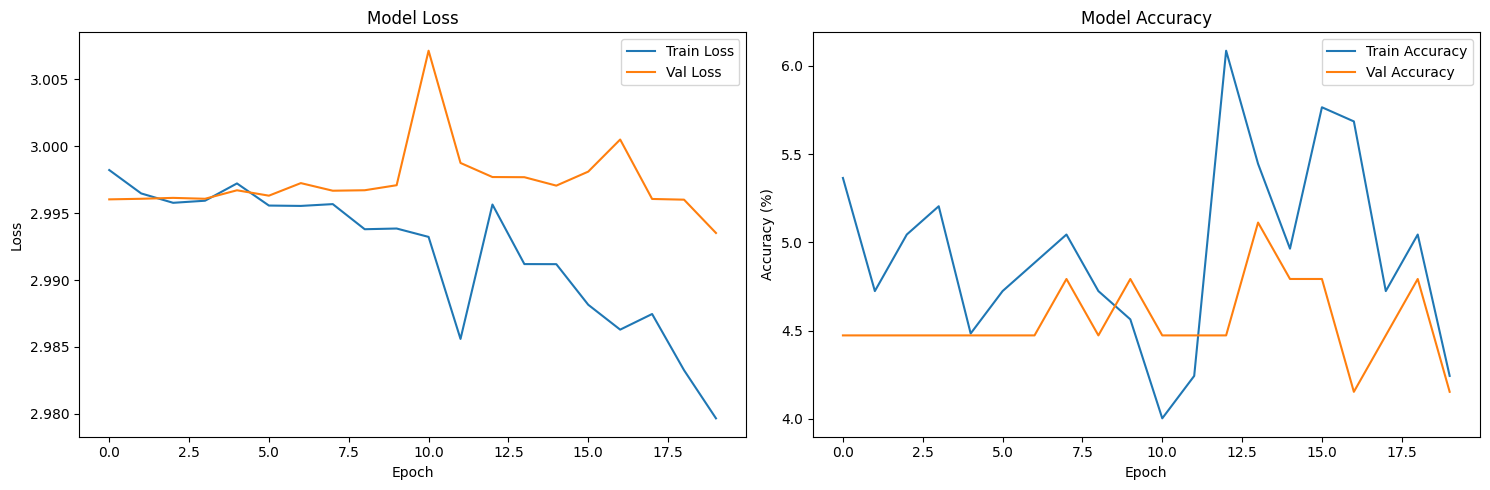

In [94]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Defining the RNN Model


Loading dataset...
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/README.md
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/LICENSE.md
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/ja/4694023059412567494_base64_34.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/ha/4694803355817399930_base64_5.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/nya/4695963539838682931_base64_38.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/la/4695952290615665559_base64_27.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/ga/4696394596413810473_base64_43.png
Skipping invalid file: /root/.cache/kagglehub/datasets/vzrenggamani/hanacaraka/versions/35/dha/4696038101413220221_base64_32.png
Skipping 

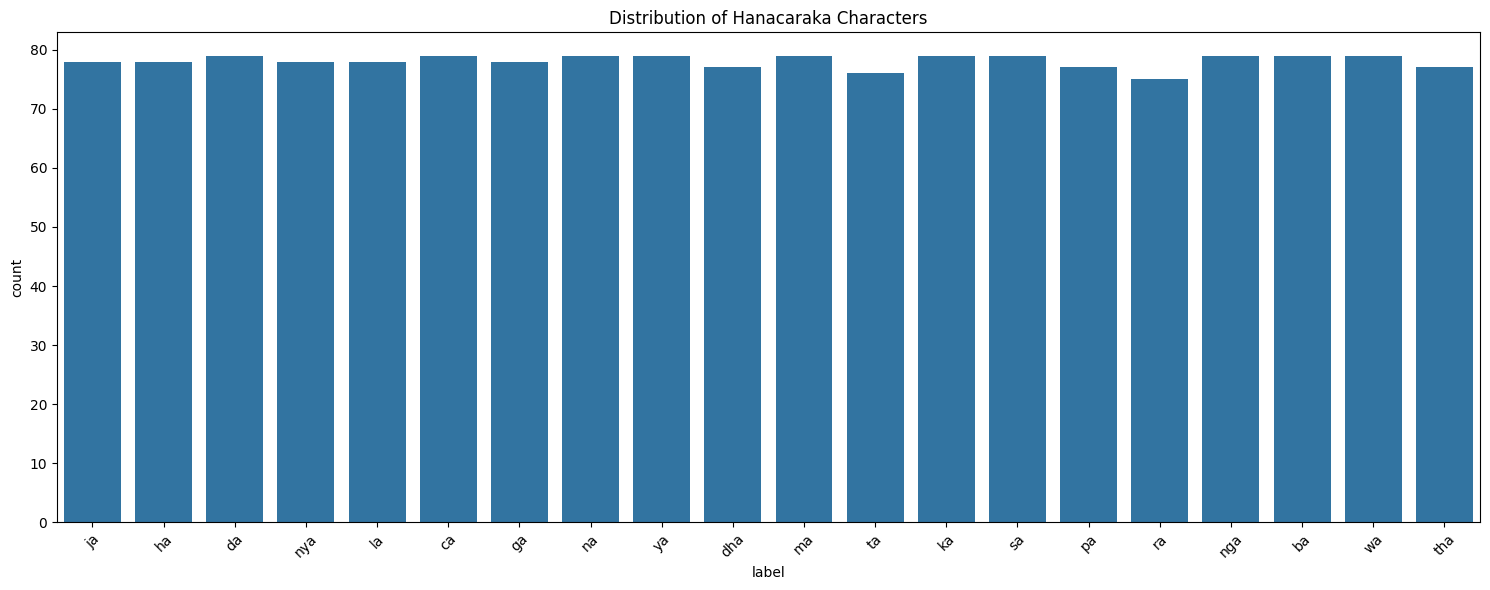


Displaying sample images...


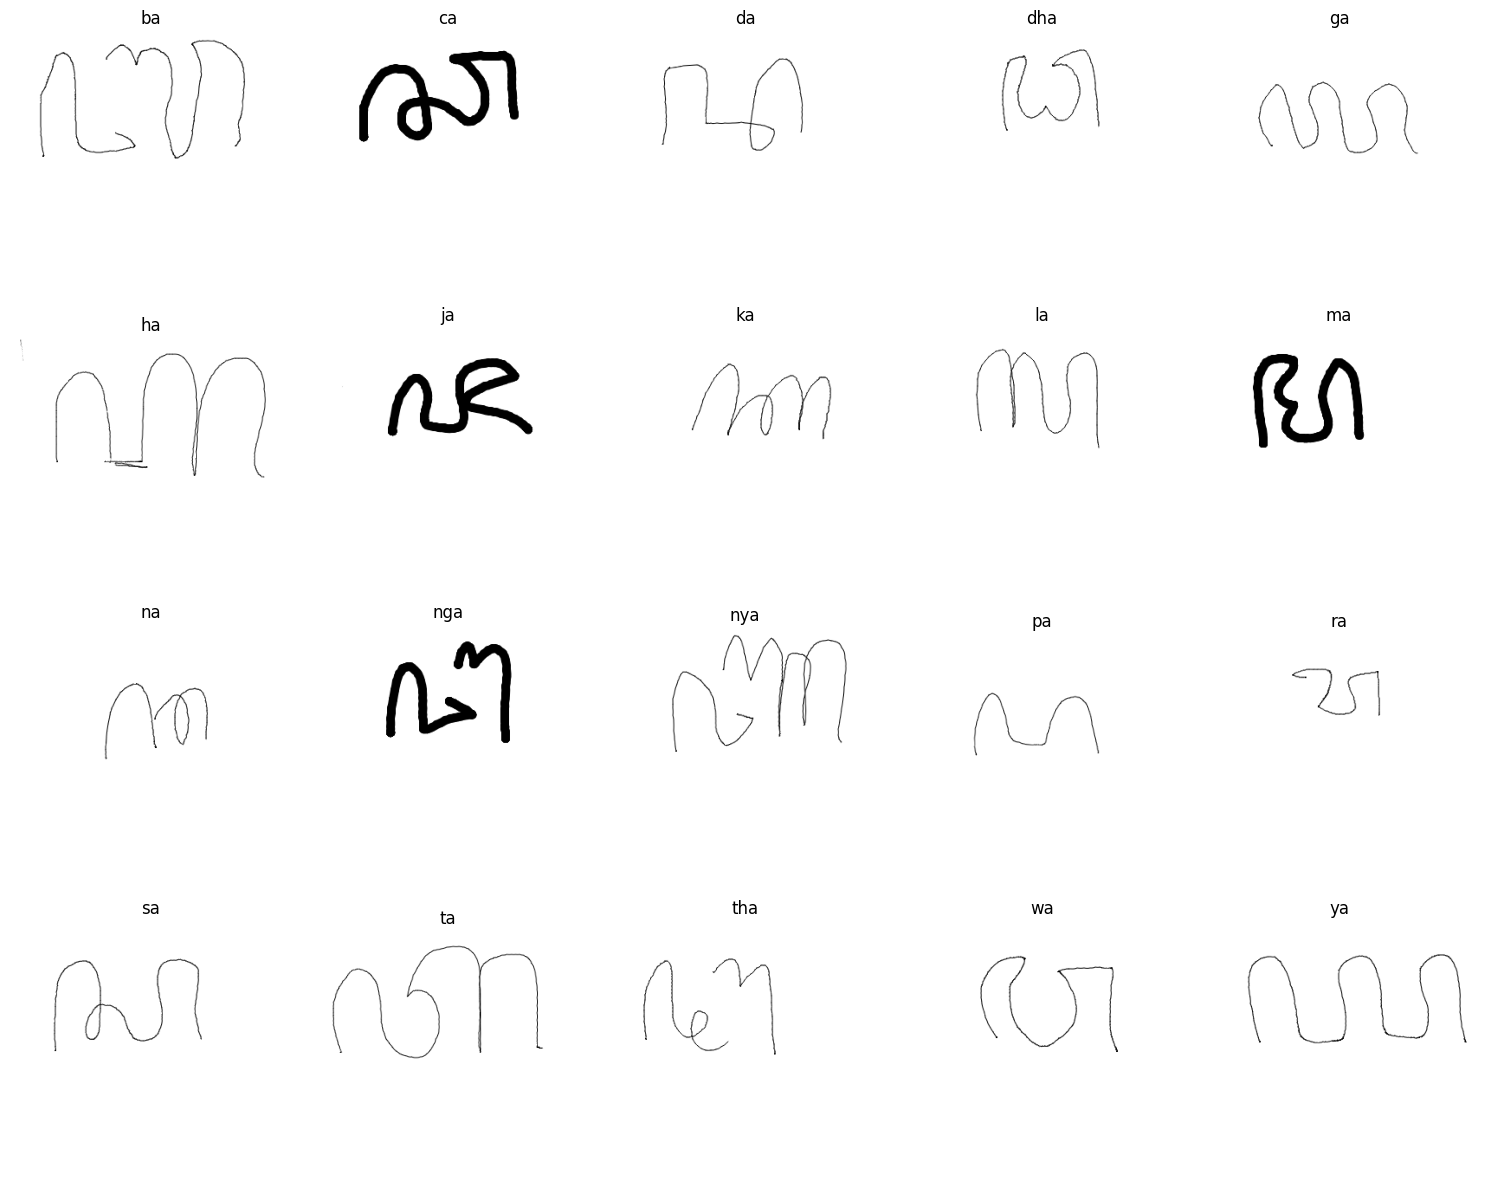

In [119]:
# Imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.files[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image: {self.files[idx]}, skipping...")
            return None
dataset = HanacarakaDataset(dataset_path)

# Encode labels and split data
label_encoder = {label: idx for idx, label in enumerate(dataset.data['label'].unique())}
labels = [label_encoder[label] for label in dataset.data['label']]

train_files, val_files, train_labels, val_labels = train_test_split(
    dataset.data['filename'], labels, test_size=0.2, random_state=42
)

# Create data loaders
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.225],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_files.values, train_labels, transform=transform)
val_dataset = ImageDataset(val_files.values, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [123]:
class ImageDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.files[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image: {self.files[idx]}, skipping...")
            return None

In [124]:
from tqdm.notebook import tqdm

def train_model_rnn_debug(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch[0], batch[1]
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape input to (batch_size, sequence_length, input_size)
            batch_size, channels, height, width = inputs.size()
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # (batch_size, height, width, channels)
            inputs = inputs.reshape(batch_size, height, -1)  # (batch_size, sequence_length=height, input_size=width*channels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch[0], batch[1]
                inputs, labels = inputs.to(device), labels.to(device)

                # Reshape for validation
                batch_size, channels, height, width = inputs.size()
                inputs = inputs.permute(0, 2, 3, 1).contiguous()  # (batch_size, height, width, channels)
                inputs = inputs.reshape(batch_size, height, -1)  # (batch_size, sequence_length=height, input_size=width*channels)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accs[-1]:.2f}% | "
              f"Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accs[-1]:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

In [125]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)  # Forward pass through RNN
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

Training Function

In [126]:
def train_model_rnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch[0], batch[1]
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape input to (batch_size, sequence_length, input_size)
            batch_size, channels, height, width = inputs.size()
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # (batch_size, height, width, channels)
            inputs = inputs.reshape(batch_size, height, -1)  # (batch_size, sequence_length=height, input_size=width*channels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch[0], batch[1]
                inputs, labels = inputs.to(device), labels.to(device)

                # Reshape for validation
                batch_size, channels, height, width = inputs.size()
                inputs = inputs.permute(0, 2, 3, 1).contiguous()  # (batch_size, height, width, channels)
                inputs = inputs.reshape(batch_size, height, -1)  # (batch_size, sequence_length=height, input_size=width*channels)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accs[-1]:.2f}% | "
              f"Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accs[-1]:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

Train the RNN

In [127]:
# Parameters
input_size = 64 * 3  # Width * Channels
hidden_size = 256    # Number of features in the hidden state
num_layers = 2       # Number of RNN layers
num_classes = len(label_encoder)

# Initialize the RNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.0001)

# Train the RNN
train_losses, val_losses, train_accs, val_accs = train_model_rnn(
    rnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device
)

Epoch 1/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.0240, Train Acc = 4.48% | Val Loss = 3.0100, Val Acc = 4.47%


Epoch 2/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: Train Loss = 3.0143, Train Acc = 4.48% | Val Loss = 3.0093, Val Acc = 4.47%


Epoch 3/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: Train Loss = 3.0219, Train Acc = 5.36% | Val Loss = 3.0065, Val Acc = 4.47%


Epoch 4/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: Train Loss = 3.0193, Train Acc = 5.12% | Val Loss = 3.0116, Val Acc = 4.47%


Epoch 5/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.0176, Train Acc = 5.28% | Val Loss = 3.0092, Val Acc = 4.79%


Epoch 6/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: Train Loss = 3.0156, Train Acc = 4.48% | Val Loss = 3.0120, Val Acc = 5.43%


Epoch 7/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: Train Loss = 3.0129, Train Acc = 4.16% | Val Loss = 3.0162, Val Acc = 3.51%


Epoch 8/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: Train Loss = 3.0137, Train Acc = 5.36% | Val Loss = 3.0063, Val Acc = 4.47%


Epoch 9/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: Train Loss = 3.0157, Train Acc = 4.48% | Val Loss = 3.0083, Val Acc = 4.79%


Epoch 10/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: Train Loss = 3.0142, Train Acc = 4.80% | Val Loss = 3.0083, Val Acc = 3.51%


Epoch 11/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: Train Loss = 3.0118, Train Acc = 5.36% | Val Loss = 3.0083, Val Acc = 4.79%


Epoch 12/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: Train Loss = 3.0081, Train Acc = 4.72% | Val Loss = 3.0154, Val Acc = 3.83%


Epoch 13/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: Train Loss = 3.0160, Train Acc = 3.92% | Val Loss = 3.0149, Val Acc = 4.79%


Epoch 14/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: Train Loss = 3.0101, Train Acc = 5.04% | Val Loss = 3.0142, Val Acc = 4.79%


Epoch 15/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: Train Loss = 3.0143, Train Acc = 4.24% | Val Loss = 3.0080, Val Acc = 5.11%


Epoch 16/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: Train Loss = 3.0117, Train Acc = 4.32% | Val Loss = 3.0113, Val Acc = 3.51%


Epoch 17/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: Train Loss = 3.0089, Train Acc = 5.44% | Val Loss = 3.0136, Val Acc = 3.51%


Epoch 18/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: Train Loss = 3.0143, Train Acc = 5.12% | Val Loss = 3.0114, Val Acc = 2.88%


Epoch 19/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: Train Loss = 3.0102, Train Acc = 4.64% | Val Loss = 3.0095, Val Acc = 4.47%


Epoch 20/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: Train Loss = 3.0091, Train Acc = 4.64% | Val Loss = 3.0087, Val Acc = 4.47%


Visualize Training Results

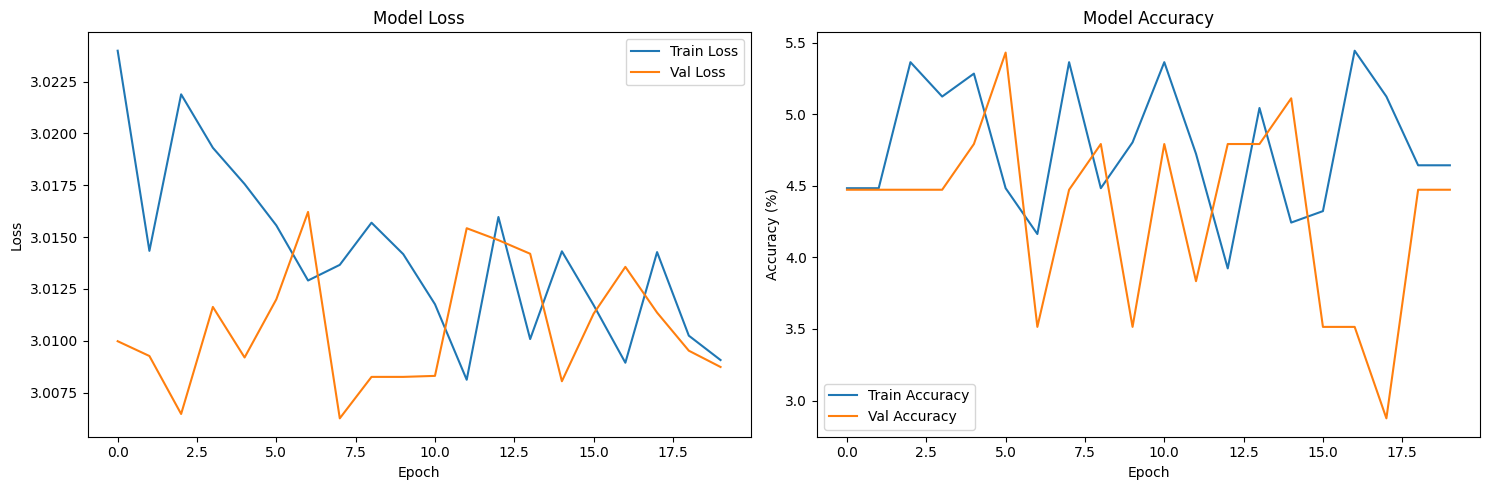

In [128]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# **LSTM**

Dataset Preparation

In [129]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.files[idx]).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image: {self.files[idx]}, skipping...")
            return None

In [130]:
# Load dataset and prepare DataLoaders
train_dataset = ImageDataset(train_files.values, train_labels)
val_dataset = ImageDataset(val_files.values, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

LSTM Model

In [131]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, _ = self.lstm(x, (h0, c0))  # Forward pass through LSTM
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        return out

Training Function

In [132]:
def train_model_lstm(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch[0], batch[1]
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape input to (batch_size, sequence_length, input_size)
            batch_size, channels, height, width = inputs.size()
            inputs = inputs.permute(0, 2, 3, 1).contiguous()  # (batch_size, height, width, channels)
            inputs = inputs.reshape(batch_size, height, -1)  # (batch_size, sequence_length=height, input_size=width*channels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch[0], batch[1]
                inputs, labels = inputs.to(device), labels.to(device)

                # Reshape for validation
                batch_size, channels, height, width = inputs.size()
                inputs = inputs.permute(0, 2, 3, 1).contiguous()  # (batch_size, height, width, channels)
                inputs = inputs.reshape(batch_size, height, -1)  # (batch_size, sequence_length=height, input_size=width*channels)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accs[-1]:.2f}% | "
              f"Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accs[-1]:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

Initialize and Train

In [133]:
# Parameters
input_size = 64 * 3  # Width * Channels
hidden_size = 256    # Number of features in the hidden state
num_layers = 2       # Number of LSTM layers
num_classes = len(label_encoder)

# Initialize the LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)

# Train the LSTM
train_losses, val_losses, train_accs, val_accs = train_model_lstm(
    lstm_model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device
)

Epoch 1/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.0051, Train Acc = 4.08% | Val Loss = 3.0027, Val Acc = 2.88%


Epoch 2/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2: Train Loss = 3.0008, Train Acc = 5.20% | Val Loss = 3.0002, Val Acc = 6.07%


Epoch 3/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3: Train Loss = 3.0015, Train Acc = 4.56% | Val Loss = 2.9995, Val Acc = 6.71%


Epoch 4/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.9999, Train Acc = 4.96% | Val Loss = 3.0037, Val Acc = 4.79%


Epoch 5/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.9983, Train Acc = 4.96% | Val Loss = 3.0017, Val Acc = 5.11%


Epoch 6/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.9986, Train Acc = 5.20% | Val Loss = 3.0057, Val Acc = 4.47%


Epoch 7/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.9978, Train Acc = 5.20% | Val Loss = 3.0038, Val Acc = 5.11%


Epoch 8/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8: Train Loss = 2.9991, Train Acc = 5.52% | Val Loss = 3.0065, Val Acc = 4.15%


Epoch 9/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9: Train Loss = 2.9968, Train Acc = 4.96% | Val Loss = 3.0046, Val Acc = 5.11%


Epoch 10/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10: Train Loss = 2.9964, Train Acc = 5.44% | Val Loss = 3.0052, Val Acc = 4.47%


Epoch 11/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11: Train Loss = 2.9950, Train Acc = 5.52% | Val Loss = 3.0087, Val Acc = 3.83%


Epoch 12/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12: Train Loss = 2.9969, Train Acc = 5.52% | Val Loss = 3.0086, Val Acc = 3.51%


Epoch 13/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13: Train Loss = 2.9985, Train Acc = 5.52% | Val Loss = 3.0080, Val Acc = 3.51%


Epoch 14/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14: Train Loss = 2.9969, Train Acc = 5.04% | Val Loss = 3.0059, Val Acc = 3.51%


Epoch 15/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15: Train Loss = 2.9976, Train Acc = 5.52% | Val Loss = 3.0058, Val Acc = 3.51%


Epoch 16/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16: Train Loss = 2.9951, Train Acc = 4.80% | Val Loss = 3.0048, Val Acc = 5.11%


Epoch 17/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17: Train Loss = 2.9949, Train Acc = 5.52% | Val Loss = 3.0086, Val Acc = 3.19%


Epoch 18/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18: Train Loss = 2.9942, Train Acc = 5.60% | Val Loss = 3.0074, Val Acc = 2.88%


Epoch 19/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19: Train Loss = 2.9948, Train Acc = 4.40% | Val Loss = 3.0063, Val Acc = 4.79%


Epoch 20/20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20: Train Loss = 2.9907, Train Acc = 5.44% | Val Loss = 3.0056, Val Acc = 2.88%


Visualize Training Results

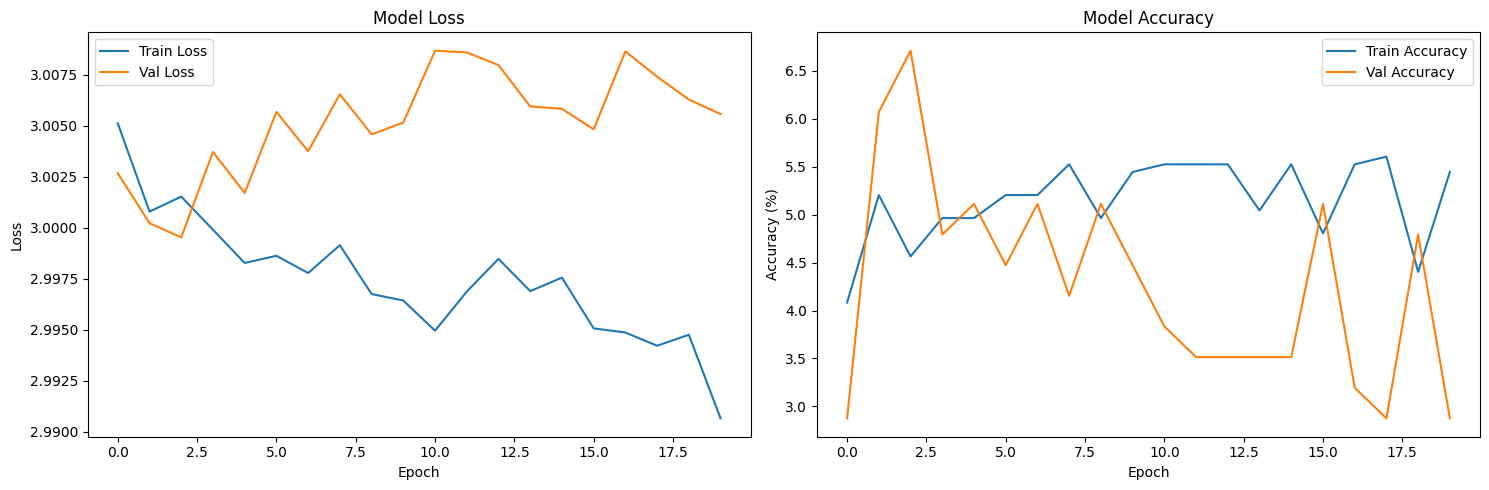

In [134]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()